### Specific Test II. Lens Finding (Method - Self-Attention CNNs)
#### **Name**: potla naga sai bharath 
#### **Gmail**:[saibharathpotla29@gmail.com](mailto:saibharathpotla29@gmail.com)
**Task:** Build a model classifying the images from \easy directory into lenses using PyTorch or Keras. Evaluate your algorithm on the images from \hard directory; note that only 20% of them have labels available, you can use the rest to train the domain adaptation model or other model of your choice. Pick the most appropriate approach and discuss your strategy.

**Dataset Description:** A dataset comprising images with and without strong lenses. Images in three different filters are available for each object. Description of columns of files containing labels (easy_test.csv and hard_test_cut.csv) is in header.txt.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

*Trained model weigths for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1DGug4hP0UZBG2zAVWiO5lAgrlnf95l_Q?usp=drive_link)*


**Strategy**:

We need to combine the images from the three different channels into one image for image classification.

The image branch consists of two Conv2D layers followed by a MaxPooling2D layer to extract features from the image data. Subsequently, the input features from the CSV file are processed through a separate branch with a dense layer, and the resulting features are concatenated with those from the image branch.

Following the concatenation, a custom self-attention layer is applied to the combined output. This attention mechanism calculates attention weights for both the image and non-image features, enabling the model to emphasize the most relevant parts of the data. The weighted sum of these features is then computed.

Finally, the output of the attention layer undergoes two Dense layers. The final layer employs a sigmoid activation function to produce a probability output.


In [1]:
import os
import random
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import numpy as np
import random
import tensorflow as tf

In [3]:
print(tf.__version__)

2.10.0


In [2]:
##########loading the file paths####################
train=r'C:\Users\sai bharath\Desktop\lens_finding\easy'
val=r'C:\Users\sai bharath\Desktop\lens_finding\hard'
trainb1=r'C:\Users\sai bharath\Desktop\lens_finding\easy\Band1'
trainb2=r'C:\Users\sai bharath\Desktop\lens_finding\easy\Band1'
trainb3=r'C:\Users\sai bharath\Desktop\lens_finding\easy\Band1'
valb1=r'C:\Users\sai bharath\Desktop\lens_finding\hard\Band1'
valb2=r'C:\Users\sai bharath\Desktop\lens_finding\hard\Band2'
valb3=r'C:\Users\sai bharath\Desktop\lens_finding\hard\Band3'

In [3]:
############### remove spam files#################
def delete_spam_files(root_folder):
    for folder, subfolders, files in os.walk(root_folder):
        for file in files:
            if file.startswith("._"):
                file_path = os.path.join(folder, file)
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
delete_spam_files(train)
delete_spam_files(val)

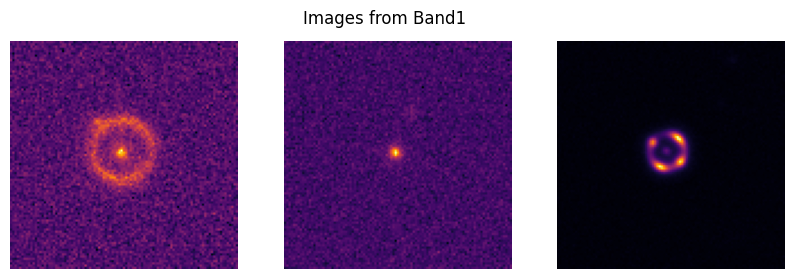

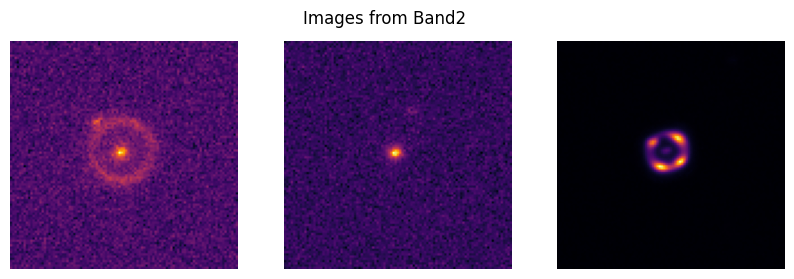

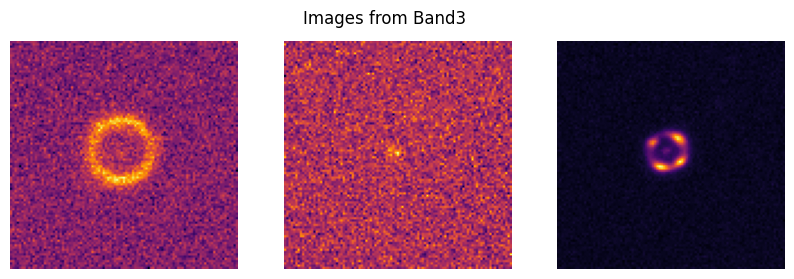

In [4]:
#####plotting images lens images############## 
import os
from astropy.io import fits
import matplotlib.pyplot as plt

# Function to load and display the first three grayscale images from each folder
def plot_images_from_folders(root_folder):
    # Loop through each subfolder
    for subdir in os.listdir(root_folder):
        subdir_path = os.path.join(root_folder, subdir)
        if os.path.isdir(subdir_path):
            images = []
            # Loop through each image in the subfolder
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                # Check if the file is a FITS file
                if file.endswith('.fits'):
                    # Open the FITS file
                    with fits.open(file_path) as hdul:
                        # Read the first HDU (Header/Data Unit)
                        data = hdul[0].data
                        images.append(data)
                        # Stop when we have collected the first three images
                        if len(images) >= 3:
                            break
            
            # Plot the images
            if images:
                plt.figure(figsize=(10, 3))
                for i, img in enumerate(images):
                    plt.subplot(1, 3, i + 1)
                    plt.imshow(img,cmap='inferno')
                    plt.axis('off')
                plt.suptitle(f'Images from {subdir}')
                plt.show()

# Path to the training folder
training_folder =r'C:\Users\sai bharath\Desktop\lens_finding\easy'

# Call the function to plot the images
plot_images_from_folders(training_folder)


In [5]:
import os
from astropy.io import fits
######################################combinding files from threes channels and saving them############################
def combine_fits_files(folder1, folder2, folder3, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        

    # Get list of files in each folder
    files1 = os.listdir(folder1)
    files2 = os.listdir(folder2)
    files3 = os.listdir(folder3)

    # Iterate through files in the first folder
    for filename1 in files1:
        # Extract common identifier
        identifier = filename1.split('-')[1].split('.')[0]  # Extracts the number part

        # Find corresponding files in other folders
        matching_files2 = [f2 for f2 in files2 if identifier in f2]
        matching_files3 = [f3 for f3 in files3 if identifier in f3]

        # Ensure there is a matching file in each folder
        if matching_files2 and matching_files3:
            # Read FITS files from each folder
            data1 = fits.getdata(os.path.join(folder1, filename1))
            data2 = fits.getdata(os.path.join(folder2, matching_files2[0]))
            data3 = fits.getdata(os.path.join(folder3, matching_files3[0]))

            # Combine data from each channel (assuming sum)
            combined_data = data1 + data2 + data3

            # Write combined data to a new FITS file in the output folder
            output_filename = f"combined_{identifier}.fits"
            fits.writeto(os.path.join(output_folder, output_filename), combined_data, overwrite=True)
           # print(f"Combined file '{output_filename}' created.")
        else:
            print(f"No matching files found for {filename1}. Skipping...")

#output_folder = r'C:\Users\sai bharath\Desktop\lens_finding\train'
#output_folder1 = r'C:\Users\sai bharath\Desktop\lens_finding\val'
#combine_fits_files(trainb1,trainb2,trainb3, output_folder)
#combine_fits_files(valb1,valb2,valb2, output_folder1)

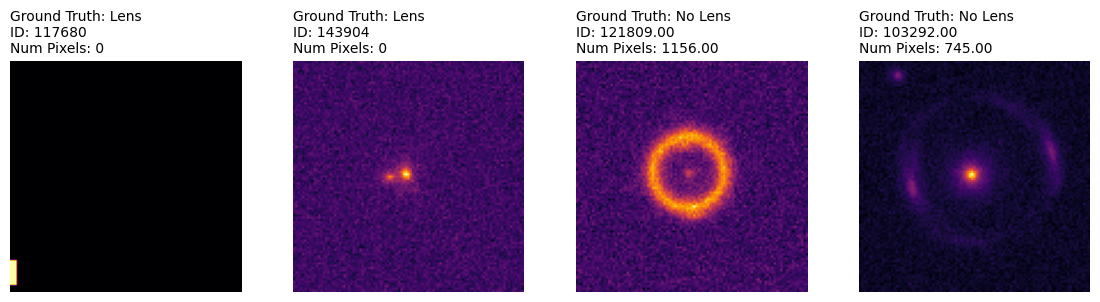

In [6]:
###############################combinding the mete data and comdinging images and plot them#################
def plot_images(df, fits_directory, batch_size=4):
    # Randomly select 4 images from the dataframe
    random_indices = random.sample(range(len(df)), batch_size)
    random_images_df = df.iloc[random_indices]
    images = []
    features = []
    image_labels = []

    for index, row in random_images_df.iterrows():
        # Load FITS image
        file_name = f"{directory}/combined_{int(row['ID'])}.fits"
        image_data = fits.getdata(file_name)
        images.append(image_data)
        # Extract additional features
        feature_vector = [row['ID'], row['numb_pix_lensed_image']]
        features.append(feature_vector)
        # Get the ground truth
        image_labels.append(row['no_source'])
    images = np.array(images)
    features = np.array(features)
    image_labels = np.array(image_labels)

    # Separate images and features by label
    label_0_images = images[np.where(image_labels == 0)]
    label_1_images = images[np.where(image_labels == 1)]
    label_0_features = features[np.where(image_labels == 0)]
    label_1_features = features[np.where(image_labels == 1)]
    # Retry if not enough images
    while len(label_0_images) < 2 or len(label_1_images) < 2:
        plot_images(df, fits_directory, batch_size)
        return
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    for i in range(2):
        axes[i].imshow(label_1_images[i].squeeze(), cmap='inferno')
        title = f'Ground Truth: Lens\nID: {label_1_features[i][0]:}\nNum Pixels: {label_1_features[i][1]:}'
        text_obj = axes[i].set_title(title, fontsize=10, ha='left')
        text_obj.set_position((-0.0, 1.0)) 
        axes[i].axis('off')

        axes[i+2].imshow(label_0_images[i].squeeze(), cmap='inferno')
        title = f'Ground Truth: No Lens\nID: {label_0_features[i][0]:.2f}\nNum Pixels: {label_0_features[i][1]:.2f}'
        text_obj = axes[i+2].set_title(title, fontsize=10,ha='left')
        text_obj.set_position((-0.0, 1.0)) 
        axes[i+2].axis('off')
    plt.show()

directory =  r'C:\Users\sai bharath\Desktop\lens_finding\train'
csv_file = r"C:\Users\sai bharath\Desktop\lens_finding/easy_test.csv"

df = pd.read_csv(csv_file)
# Plot the images
plot_images(df, directory)

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from keras import layers, models, Model, Input

from keras.metrics import Accuracy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Concatenate, Softmax, Reshape, Add, Activation

import keras
import tensorflow as tf
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.nn.tanh(tf.linalg.matmul(inputs, self.W))
        a = tf.nn.softmax(q, axis=1)
        weighted_sum = tf.reduce_sum(inputs * a, axis=1)
        return tf.expand_dims(weighted_sum, axis=-1)

In [8]:
def image_branch(input_image):
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return Dense(64, activation='relu')(x)

def feature_branch(input_features):
    x = Dense(32, activation='relu')(input_features)
    return x

def cnn_with_attention():
    # Image input branch
    input_image = Input(shape=(101, 101, 1))
    image_output = image_branch(input_image)

    # Additional features input branch
    input_features = Input(shape=(1,))
    feature_output = feature_branch(input_features)

    # Concatenate the branches
    combined = Concatenate()([image_output, feature_output])
    
    # Attention mechanism
    attention = AttentionLayer()(combined)

    # Final layers
    x = Dense(64, activation='relu')(attention)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=[input_image, input_features], outputs=output)

    return model

In [9]:
model = cnn_with_attention()

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 101, 101, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 101, 101, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 50, 50, 16)   0           ['conv2d[0][0]']                 
                                                                                              

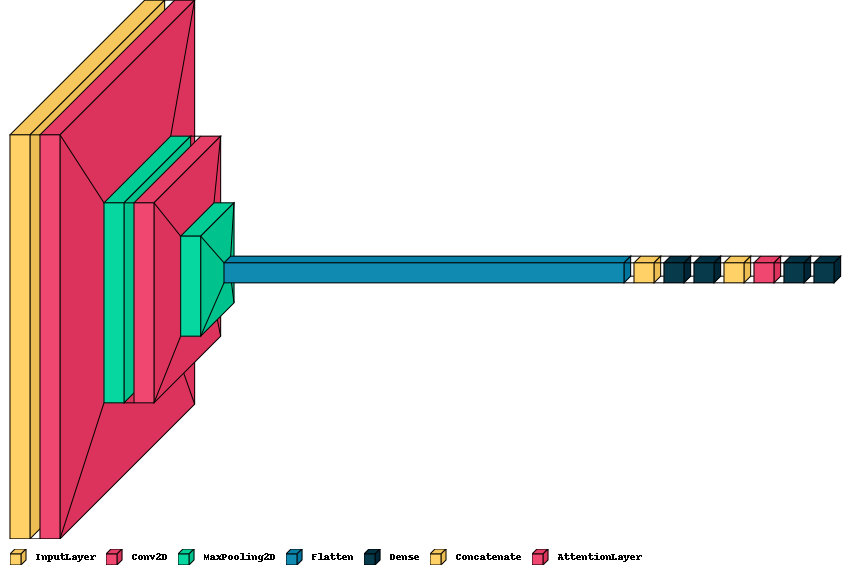

In [11]:
###visualization of the cnn cnn architecture###
#!pip install visualkeras(for install visualkeas please uncomment )
import visualkeras
visualkeras.layered_view(model, legend=True)

In [12]:
def data_generator(df, fits_directory, batch_size):  
    while True:
        # Shuffle the dataframe
        df = df.sample(frac=1).reset_index(drop=True)

        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]

            # Load the FITS images and extract the additional features
            images = []
            features = []
            labels = []

            for index, row in batch_df.iterrows():
                # Load FITS image
                file_name = f"{fits_directory}/combined_{int(row['ID'])}.fits"
                image_data = fits.getdata(file_name)
                images.append(image_data)

                # Extract additional features
                feature_vector = [row['numb_pix_lensed_image']]
                features.append(feature_vector)

                # Get the ground truth
                labels.append(row['no_source'])

            # Convert lists to numpy arrays
            images = np.array(images)
            features = np.array(features)
            labels = np.array(labels)

            yield [images, features], labels

In [13]:
fits_directorytrain  = r'C:\Users\sai bharath\Desktop\lens_finding\train'
fits_directoryval=r'C:\Users\sai bharath\Desktop\lens_finding\val'
csv_filetrain = r"C:\Users\sai bharath\Desktop\lens_finding/easy_test.csv"
csv_drectoryval=r"C:\Users\sai bharath\Desktop\lens_finding/hard_test_cut.csv"

In [14]:
batch_size = 128
dftr = pd.read_csv(csv_filetrain )
dfval=pd.read_csv(csv_drectoryval)
steps_per_epoch = len(dftr) // batch_size
validation_steps = len(dfval) // batch_size  
train_generator = data_generator(dftr, fits_directorytrain, batch_size)
validation_generator = data_generator(dfval,fits_directoryval, batch_size)

In [15]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
checkpoint = ModelCheckpoint("lens_finding_checkpoint.h5", monitor='val_auc', verbose=1, save_best_only=True, mode='max')

In [16]:
#from astropy.io import fits
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=validation_generator, validation_steps=validation_steps,callbacks = [checkpoint])

Epoch 1/20
93/93 [==============================] - ETA: 0s - loss: 42.0654 - auc: 0.6800
Epoch 1: val_auc improved from -inf to 1.00000, saving model to lens_finding_checkpoint.h5
93/93 [==============================] - 58s 551ms/step - loss: 42.0654 - auc: 0.6800 - val_loss: 0.3382 - val_auc: 1.0000
Epoch 2/20
93/93 [==============================] - ETA: 0s - loss: 0.3317 - auc: 1.0000
Epoch 2: val_auc did not improve from 1.00000
93/93 [==============================] - 14s 152ms/step - loss: 0.3317 - auc: 1.0000 - val_loss: 0.3166 - val_auc: 1.0000
Epoch 3/20
93/93 [==============================] - ETA: 0s - loss: 0.3105 - auc: 1.0000
Epoch 3: val_auc did not improve from 1.00000
93/93 [==============================] - 13s 146ms/step - loss: 0.3105 - auc: 1.0000 - val_loss: 0.2945 - val_auc: 1.0000
Epoch 4/20
93/93 [==============================] - ETA: 0s - loss: 0.2902 - auc: 1.0000
Epoch 4: val_auc did not improve from 1.00000
93/93 [==============================] - 13s 14

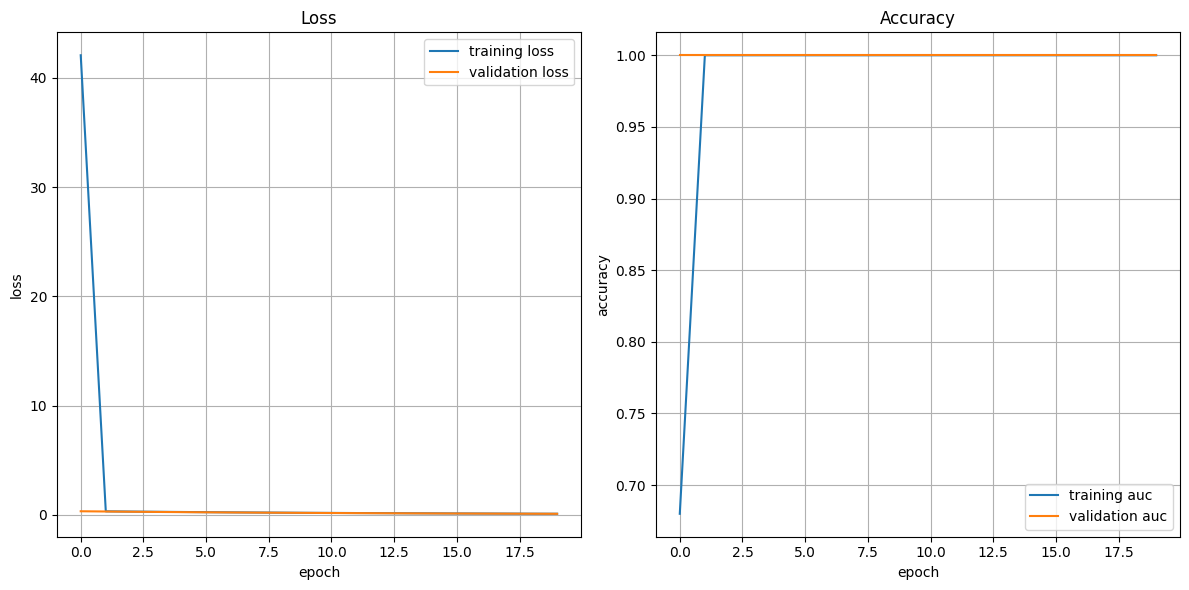

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.grid()
# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='training auc')
plt.plot(history.history['val_auc'], label='validation auc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [18]:
model.save('Self-Attention.h5')

In [19]:
from tensorflow.keras.models import load_model
reconstructed_model = keras.models.load_model("Self-Attention.h5",custom_objects={"AttentionLayer": AttentionLayer})#compile=False(if you are using another version of tensorflow )

In [20]:
# Load the FITS images and extract the additional features
images = []
features = []
labels = []

for index, row in dfval.iterrows():
    # Load FITS image
    file_name = f"{fits_directoryval}/combined_{int(row['ID'])}.fits"
    image_data = fits.getdata(file_name)
    images.append(np.expand_dims(image_data, axis=-1))  # Add channel dimension

    # Extract additional features
    feature_vector = [row['numb_pix_lensed_image']]
    features.append(feature_vector)

    # Get the ground truth
    labels.append(row['no_source'])
# Convert lists to numpy arrays
images = np.array(images)
features = np.array(features)
labels = np.array(labels)

82/82 [==============================] - 1s 4ms/step


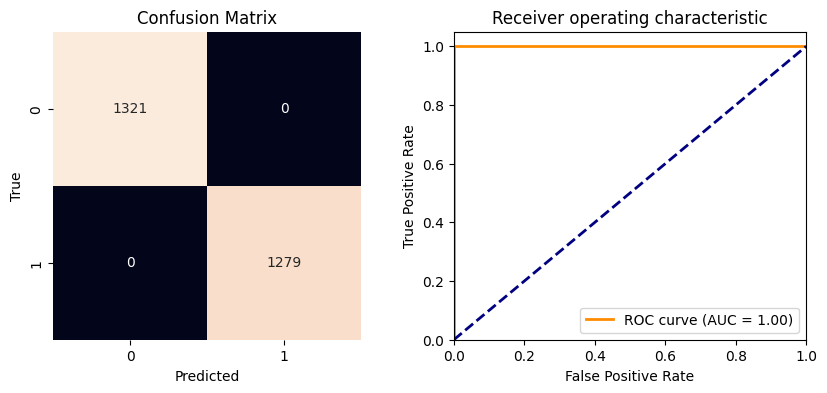

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

y_true = dfval['no_source'].values
y_pred = (reconstructed_model.predict([images, features]) > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(y_true, y_pred)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cbar=False, square=True, ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix')

# Plot the ROC curve
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver operating characteristic')
axs[1].legend(loc="lower right")

plt.show()